In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import json
from tqdm import tqdm
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

/home/petr/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Часть 1

## Блекждек со стандартными правилами

#### 1) Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 


Далее по ходу решения задачи будем использоваться $\gamma = 1$, потому что этот параметр используется для исключения зацикленности в выгодных состояниях, но наша игра всегда конечная и нам не нужно подгонять алгоритм скорее выбить нам награду.

Также будем использовать только Q-learning во всех пунктах, чтобы сравнивать не методы, а разные постановки задачи

In [97]:
basic_env = gym.make('Blackjack-v1', sab=False, natural=True)

ACTIONS = (0, 1)
STATES = tuple([obs for obs in itertools.product(range(4, 32), range(1, 11), (True, False)) if (obs[2] is True and 11 < obs[0] < 22) or (obs[2] is False)])

In [2]:
def run_episode(env, pi):
    observation = env.reset()
    rewards = []
    while True:
        observation, reward, done, info = env.step(pi[observation])
        rewards.append(reward)
        if done:
            break
    return rewards[-1]


def conduct_experiments_pi(env, pi, num_experiments=50000):
    total_reward = []
    for i in range(num_experiments):
        reward = run_episode(env, pi)
        total_reward.append(reward)
    return np.mean(total_reward)


def compute_policy_by_Q(Q):
    pi = np.argmax(Q, axis=1)
    return {STATES[i]: pi[i] for i in range(len(STATES))}


def Q_learning_episode(env, Q, alpha=0.05, epsilon=0.0, gamma=1.0):
    observation = env.reset()
    pi = compute_policy_by_Q(Q)
    
    while True:
        action = pi[observation] if np.random.rand() > epsilon else np.random.choice(ACTIONS)
        new_obs, reward, done, info = env.step(action)
        obs_idx = STATES.index(observation)
        Q[obs_idx, action] = Q[obs_idx, action] + \
                            alpha * (reward + gamma * np.max(Q[STATES.index(new_obs)]) - \
                            Q[obs_idx, action])
        observation = new_obs
        if done:
            break
    return Q


skip_episodes = 2000

def Q_learning(env, Q, num_episodes=100000, num_experiments=10000, alpha=0.05, epsilon=0.0, gamma=1.0, to_plot=False):
    q_rewards = []

    for i in tqdm(range(num_episodes)):
        Q = Q_learning_episode(env, Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
        if to_plot and i % skip_episodes == 0:
            pi = compute_policy_by_Q(Q)
            q_rewards.append(conduct_experiments_pi(env, pi, num_experiments=num_experiments))

    if to_plot:
        return q_rewards
    else:
        return conduct_experiments_pi(env, compute_policy_by_Q(Q), num_experiments=num_experiments)

In [37]:
simple_pi = {observation: int(observation[0] not in [19, 20, 21]) for observation in STATES}

simple_reward = conduct_experiments_pi(basic_env, simple_pi, num_experiments=500000)
print(f'Простая стратегия в среднем дает награду {simple_reward}')

Простая стратегия в среднем дает награду -0.180447


#### 2) Реализуем Q-learning для нашей формулировки

In [23]:
Q = np.zeros((len(STATES), len(ACTIONS)))
basic_env_q_reward = Q_learning(basic_env, Q)

print(f'Q-learning по завершении 100_000 эпизодов в среднем дает награду {basic_env_q_reward}')

Q-learning по завершении 100_000 эпизодов в среднем дает награду -0.1788


#### 3) Попробуем подобрать гиперпараметры $\alpha$ и $\varepsilon$:

In [26]:
best_reward, best_alpha, best_eps = - np.inf, 0, 0
for alpha in np.linspace(0.00003, 0.2, 10):
    print(f'alpha = {round(alpha, 5)}:')
    for eps in np.linspace(0, 0.5, 5):
        Q = np.zeros((len(STATES), len(ACTIONS)))
        val_reward = Q_learning(basic_env, Q, num_episodes=10000, num_experiments=5000, alpha=alpha, epsilon=eps)
        print('\t', f'epsilon = {round(eps, 3)}:', '\t', f'REWARD = {val_reward}')
        if val_reward > best_reward:
            best_reward, best_alpha, best_eps = val_reward, alpha, eps

print('\n', f'BEST_ALPHA = {round(best_alpha, 5)}, BEST_EPSILON = {round(best_eps, 3)}:      BEST_REWARD = {best_reward}')

alpha = 3e-05:
	 epsilon = 0.0: 	 REWARD = -0.0632
	 epsilon = 0.125: 	 REWARD = -0.0649
	 epsilon = 0.25: 	 REWARD = -0.0767
	 epsilon = 0.375: 	 REWARD = -0.0678
	 epsilon = 0.5: 	 REWARD = -0.0569
alpha = 0.02225:
	 epsilon = 0.0: 	 REWARD = -0.1096
	 epsilon = 0.125: 	 REWARD = -0.0658
	 epsilon = 0.25: 	 REWARD = -0.0782
	 epsilon = 0.375: 	 REWARD = -0.0846
	 epsilon = 0.5: 	 REWARD = -0.0701
alpha = 0.04447:
	 epsilon = 0.0: 	 REWARD = -0.1078
	 epsilon = 0.125: 	 REWARD = -0.0957
	 epsilon = 0.25: 	 REWARD = -0.152
	 epsilon = 0.375: 	 REWARD = -0.1139
	 epsilon = 0.5: 	 REWARD = -0.1072
alpha = 0.06669:
	 epsilon = 0.0: 	 REWARD = -0.1107
	 epsilon = 0.125: 	 REWARD = -0.1004
	 epsilon = 0.25: 	 REWARD = -0.1229
	 epsilon = 0.375: 	 REWARD = -0.1444
	 epsilon = 0.5: 	 REWARD = -0.122
alpha = 0.08891:
	 epsilon = 0.0: 	 REWARD = -0.154
	 epsilon = 0.125: 	 REWARD = -0.1365
	 epsilon = 0.25: 	 REWARD = -0.1271
	 epsilon = 0.375: 	 REWARD = -0.1413
	 epsilon = 0.5: 	 REWARD = -0.

Видно, что результаты лучше при маленьких $\alpha$ 

In [27]:
best_reward, best_alpha, best_eps = - np.inf, 0, 0
for alpha in np.linspace(0.00001, 0.0005, 10):
    print(f'alpha = {round(alpha, 5)}:')
    for eps in np.linspace(0, 0.5, 5):
        Q = np.zeros((len(STATES), len(ACTIONS)))
        val_reward = Q_learning(basic_env, Q, num_episodes=10000, num_experiments=5000, alpha=alpha, epsilon=eps)
        print('\t', f'epsilon = {round(eps, 3)}:', '\t', f'REWARD = {val_reward}')
        if val_reward > best_reward:
            best_reward, best_alpha, best_eps = val_reward, alpha, eps

print('\n', f'BEST_ALPHA = {round(best_alpha, 5)}, BEST_EPSILON = {round(best_eps, 3)}:      BEST_REWARD = {best_reward}')

alpha = 1e-05:
	 epsilon = 0.0: 	 REWARD = -0.0304
	 epsilon = 0.125: 	 REWARD = -0.0419
	 epsilon = 0.25: 	 REWARD = -0.0444
	 epsilon = 0.375: 	 REWARD = -0.0374
	 epsilon = 0.5: 	 REWARD = -0.0626
alpha = 6e-05:
	 epsilon = 0.0: 	 REWARD = -0.0895
	 epsilon = 0.125: 	 REWARD = -0.0775
	 epsilon = 0.25: 	 REWARD = -0.0549
	 epsilon = 0.375: 	 REWARD = -0.0644
	 epsilon = 0.5: 	 REWARD = -0.1044
alpha = 0.00012:
	 epsilon = 0.0: 	 REWARD = -0.0775
	 epsilon = 0.125: 	 REWARD = -0.0469
	 epsilon = 0.25: 	 REWARD = -0.084
	 epsilon = 0.375: 	 REWARD = -0.0624
	 epsilon = 0.5: 	 REWARD = -0.065
alpha = 0.00017:
	 epsilon = 0.0: 	 REWARD = -0.0821
	 epsilon = 0.125: 	 REWARD = -0.0923
	 epsilon = 0.25: 	 REWARD = -0.064
	 epsilon = 0.375: 	 REWARD = -0.0642
	 epsilon = 0.5: 	 REWARD = -0.0623
alpha = 0.00023:
	 epsilon = 0.0: 	 REWARD = -0.0418
	 epsilon = 0.125: 	 REWARD = -0.0843
	 epsilon = 0.25: 	 REWARD = -0.0592
	 epsilon = 0.375: 	 REWARD = -0.058
	 epsilon = 0.5: 	 REWARD = -0.032

In [110]:
Q = np.zeros((len(STATES), len(ACTIONS)))
num_episodes = 250000
basic_env_q_rewards = Q_learning(basic_env, Q, num_episodes=num_episodes, num_experiments=1000, alpha=1e-5, epsilon=0.1, to_plot=True)

print(f'Q-learning по завершении {num_episodes} эпизодов в среднем дает награду {basic_env_q_rewards[-1]}')

Q-learning по завершении 500000 эпизодов в среднем дает награду -0.067


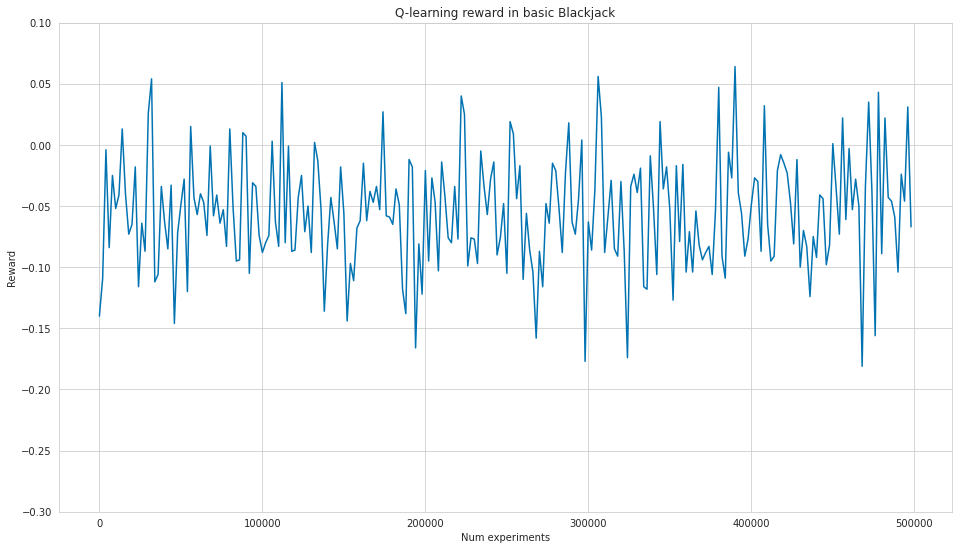

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('Q-learning reward in basic Blackjack')
plt.plot(range(0, num_episodes, skip_episodes), basic_env_q_rewards)
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.ylim((-0.3, 0.1))
plt.show()

#### По графику можем заметить, что начальное приближение Q нулями очень хорошее (даже на первом эпизоде получаем неплохую награду). При попытке взять случайное Q результат был хуже, поэтому продолжим инициализировать Q нулями и дальше.

# Часть 2

## Добавим возможность удваивать ставку

In [4]:
from gym.envs.toy_text.blackjack import *

class DoubleBlackjackEnv(gym.envs.toy_text.BlackjackEnv):
    def __init__(self, natural=True, sab=False, double=True):
        super(DoubleBlackjackEnv ,self).__init__()
        if double:
            self.action_space = gym.spaces.Discrete(3)
        self.natural = natural
        self.sab = sab
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2: # double: 
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0 * 2
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

In [18]:
double_env = DoubleBlackjackEnv()
ACTIONS = (0, 1, 2)
STATES = tuple([obs for obs in itertools.product(range(4, 32), range(1, 11), (True, False)) if (obs[2] is True and 11 < obs[0] < 22) or (obs[2] is False)])

Q = np.zeros((len(STATES), len(ACTIONS)))
num_episodes = 500000


double_env_q_rewards = Q_learning(double_env, Q, num_episodes=num_episodes, num_experiments=1000, alpha=1e-5, epsilon=0.1, to_plot=True)
print(f'Q-learning с возможностью удвоения по завершении {num_episodes} эпизодов в среднем дает награду {double_env_q_rewards[-1]}')

100%|██████████| 500000/500000 [02:04<00:00, 4008.27it/s]

Q-learning с возможностью удвоения по завершении 500000 эпизодов в среднем дает награду -0.023


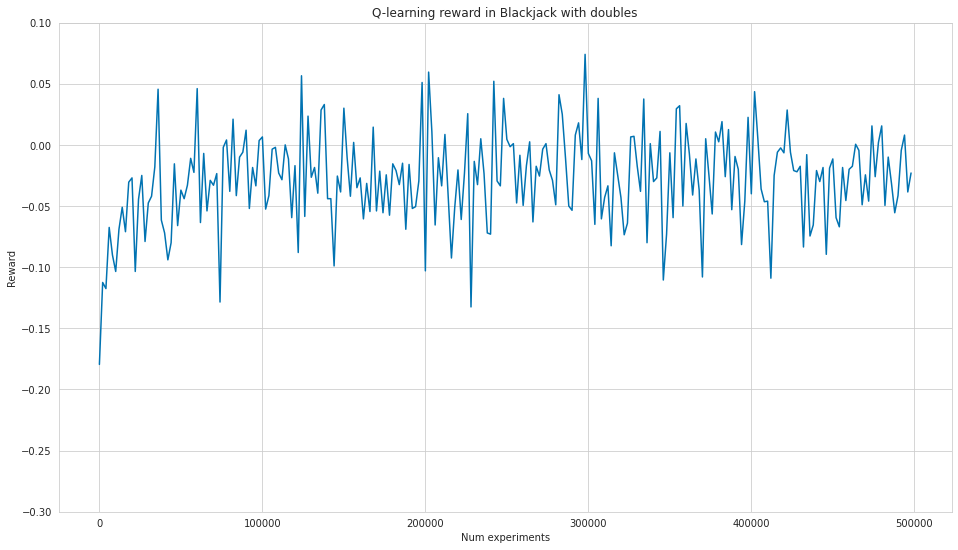

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('Q-learning reward in Blackjack with doubles')
plt.plot(range(0, num_episodes, skip_episodes), double_env_q_rewards)
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.ylim((-0.3, 0.1))
plt.show()

#### Получили лучшие результаты, но казино так и не обыграли

# Часть 3

## Начинаем считать карты

In [5]:
counting_rule = {1: range(2, 7), 0: range(7, 10), -1: [1, 10]}
counting_rule = {x: k for k, v in counting_rule.items() for x in v}


class DoubleBlackjackEnvWithCounting(gym.envs.toy_text.BlackjackEnv):
    def __init__(self, natural=True, sab=False, double=True, counting=True):
        super(DoubleBlackjackEnvWithCounting ,self).__init__()
        if double:
            self.action_space = gym.spaces.Discrete(3)
        if counting:
            self.observation_space = spaces.Tuple(
                (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(29))
            )
        self.natural = natural
        self.sab = sab
        
        self.make_new_deck()
        self.count = 0
        
    def make_new_deck(self):
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)
        self.count += counting_rule[card]
        return card
    
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2: # double: 
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0 * 2
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}
    
    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.count)
    
    def reset(self):
        if len(self.deck) < 15:
            self.make_new_deck()
            self.count = 0
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [24]:
double_env_with_counting = DoubleBlackjackEnvWithCounting()

ACTIONS = (0, 1, 2)
STATES = tuple([obs for obs in itertools.product(range(4, 32), range(1, 11), (True, False), range(-8, 21)) if (obs[2] is True and 11 < obs[0] < 22) or (obs[2] is False)])


Q = np.zeros((len(STATES), len(ACTIONS)))
num_episodes = 250000

double_env_with_counting_q_rewards = Q_learning(double_env_with_counting, Q, num_episodes=num_episodes, num_experiments=1000, alpha=1e-5, epsilon=0.1, to_plot=True)
print(f'Q-learning с возможностью удвоения и счета карт по завершении {num_episodes} эпизодов в среднем дает награду {double_env_with_counting_q_rewards[-1]}')

100%|██████████| 250000/250000 [16:37<00:00, 250.60it/s]

Q-learning с возможностью удвоения и счета карт по завершении 250000 эпизодов в среднем дает награду -0.0565


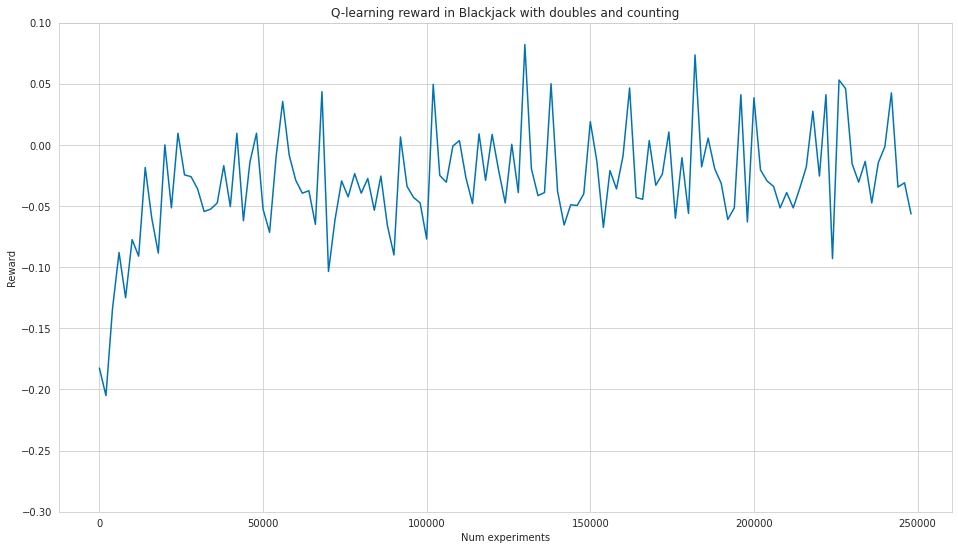

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plt.title('Q-learning reward in Blackjack with doubles and counting')
plt.plot(range(0, num_episodes, skip_episodes), double_env_with_counting_q_rewards)
plt.xlabel('Num experiments')
plt.ylabel('Reward')
plt.ylim((-0.3, 0.1))
plt.show()

#### Видим, что в среднем по графику награда почти достигла 0, и довольно часто появляются пики, где награда больше нуля. Результат лучше, чем в предыдущих сценариях, но казино так обыграть и не удалось.